In [1]:
import os
import shutil
import random
import torch
import glob
import numpy as np
from torch.utils.data import Subset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision.models import vgg19, VGG19_Weights
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from PIL import Image
from torch.utils.data import SubsetRandomSampler

# **✅ 학습 데이터셋의 RGB 채널별 평균 및 표준편차 계산**

In [2]:
import cv2
from tqdm import tqdm

image_dir = "/content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축/VGG19_Project/data/santa/train"

pixel_sum = np.zeros(3)
pixel_sum_sq = np.zeros(3)
pixel_count = 0

for root, _, files in os.walk(image_dir):
    for file in tqdm(files):
        if file.endswith(('.jpg', '.png', '.jpeg')):
            img_path = os.path.join(root, file)

            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32) / 255.0  # 정규화 전 단계

            pixel_sum += img.sum(axis=(0,1))
            pixel_sum_sq += (img ** 2).sum(axis=(0,1))
            pixel_count += img.shape[0] * img.shape[1]

mean = pixel_sum / pixel_count
std = np.sqrt(pixel_sum_sq / pixel_count - mean ** 2)

print(f"평균: {mean}")
print(f"표준편차: {std}")

0it [00:00, ?it/s]
100%|██████████| 449/449 [00:13<00:00, 33.84it/s]

평균: [0.5429284  0.43834987 0.41621647]
표준편차: [0.28189653 0.32122606 0.3198775 ]


# **✅ 이미지 전처리 및 정규화 변환 정의**

In [3]:
# transform은 데이터들을 0~255 값들을 0~1로 정규화 시킨다.
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 데이터 증강
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

In [4]:
image_datasets = {
    'train': datasets.ImageFolder('/content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축/VGG19_Project/data/santa/train', transform=transform_train),
    'validation': datasets.ImageFolder('/content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축/VGG19_Project/data/santa/val', transform=transform_val),
}

In [5]:
BATCH_SIZE = 32

train_loader = DataLoader(dataset=image_datasets['train'], batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(dataset=image_datasets['validation'], batch_size = BATCH_SIZE, shuffle = False)

In [6]:
train_features, train_labels = next(iter(train_loader))
print(train_labels.shape, train_labels.dtype)

torch.Size([32]) torch.int64


# **✅ 학습 데이터 배치 이미지 시각화**

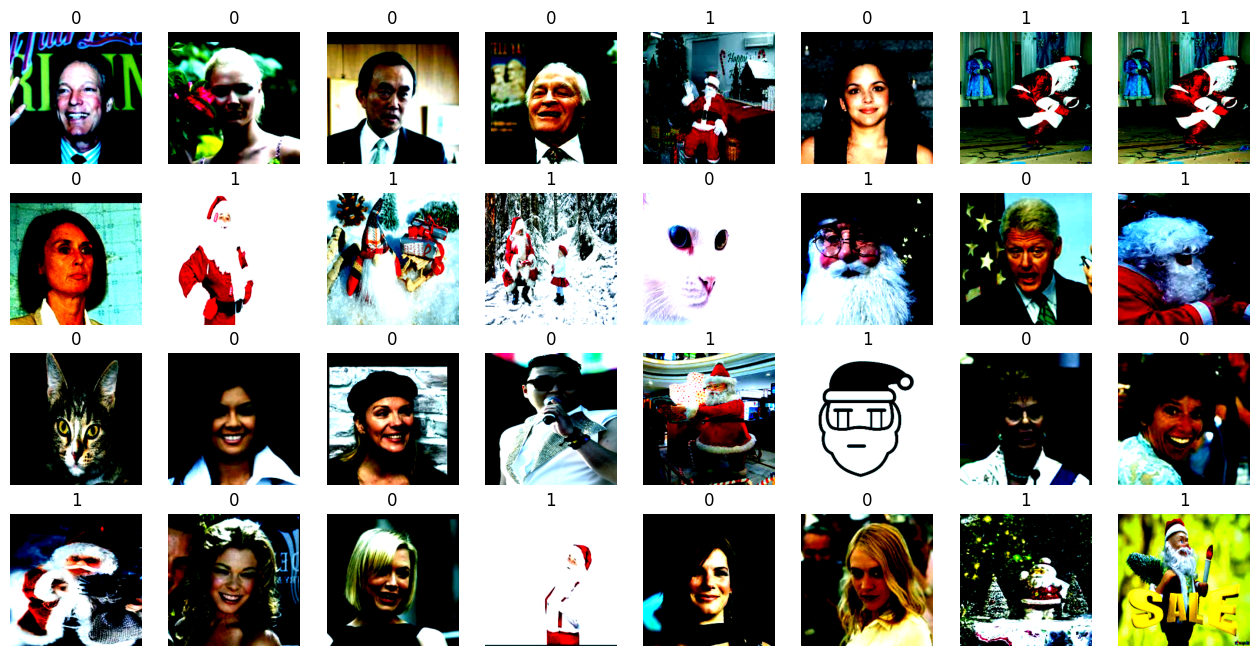

In [7]:
imgs, labels = next(iter(train_loader))

fig, axes = plt.subplots(4, 8, figsize=(16, 8))

for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.permute(1, 2, 0)) # (3, 224, 224) -> (224, 224, 3)
    ax.set_title(label.item())
    ax.axis('off')

# **✅ 학습·검증 데이터셋 클래스 인덱스 확인**

In [8]:
print(image_datasets['train'].class_to_idx)
print(image_datasets['validation'].class_to_idx)

{'normal': 0, 'santa': 1}
{'normal': 0, 'santa': 1}


# **✅ VGG19 모델 구조 직접 구현 (Conv2d + ReLU 기반)**

In [9]:
from torch.nn.modules.activation import ReLU
from torch.nn.modules.conv import Conv2d
# VGG19 모델 직접 구현
class VGG19(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG19, self).__init__()
        self.features = nn.Sequential(
            # 3, 224, 224
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),  # Conv1
            nn.ReLU(inplace=True),
            # 64, 224, 224
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),  # Conv2
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # max 1 64, 112, 112

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1), # Conv3
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1), # Conv4
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # max 2 128, 56, 56

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1), # Conv5
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1), # Conv6
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1), # Conv7
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1), # Conv8
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # max 3 256, 28, 28

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1), # Conv9
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1), # Conv10
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1), # Conv11
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1), # Conv12
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # max 4 512, 14, 14

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1), # Conv13
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1), # Conv14
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1), # Conv15
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1), # Conv16
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) # max 5 512, 7, 7
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),  # FC1 (Flatten 크기 조정)
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(4096, 4096),        # FC2
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(4096, num_classes), # FC3
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten
        x = self.classifier(x)
        return x

# **✅ BatchNorm을 포함한 경량 VGG19(Small) 모델 구조 정의**

- BatchNorm을 사용하면 각 레이어의 입력 분포를 안정화시켜 학습을 더 빠르고 안정적으로 만들고, 과적합을 줄이는 데 도움을 준다

In [ ]:
class VGG19_Small(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112

            # Block 2
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56

            # Block 3
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28x28

            # Block 4
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14x14
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# **✅ BatchNorm 미사용 경량 VGG19(Small) 모델 구조 정의**

### ❓ 왜 BatchNorm을 사용하지 않은 버전을 함께 실험해봤을까 ?

- 모델의 성능 향상이 BatchNorm 때문인지, 아니면 레이어 수를 줄인 구조 자체의 효과인지를 분리해서 확인하기 위해서
- BatchNorm은 학습을 안정화시키는 장점이 있지만, 현재처럼 모델이 비교적 얕고 데이터 분포가 이미 정규화된 상황에서는 성능에 미치는 영향이 크지 않을 수 있다.
- 그래서 BatchNorm을 제거한 모델을 함께 학습시켜 구조적 단순화의 효과와 BatchNorm의 기여도를 명확히 비교하려는 목적의 실험이다.

In [27]:
class VGG19_Small_NoBN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 112x112

            # Block 2
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 56x56

            # Block 3
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 28x28

            # Block 4
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 14x14
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [28]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

# **✅ 클래스 불균형을 보정하기 위한 가중치 기반 손실 함수 설정**

In [29]:
from collections import Counter

targets = image_datasets['train'].targets
counter = Counter(targets)

num_normal = counter[0]  # 'normal'
num_santa  = counter[1]  # 'santa'

In [30]:
w = num_normal / num_santa
criterion = nn.CrossEntropyLoss(
    weight=torch.tensor([1.0, w], device=DEVICE)
)

# **✅ 여러 Optimizer(SGD / Adam / RAdam)를 비교하기 위한 공통 학습·검증 루프 함수**

In [31]:
def train_model(optimizer_name, model, train_loader, val_loader, criterion, num_epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # optimizer 설정
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
    elif optimizer_name == 'RAdam':
        optimizer = optim.RAdam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    # 학습/검증 손실과 검증 정확도를 저장할 리스트
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()  # 모델을 학습 모드로 설정
        running_loss = 0.0

        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # 매 에포크마다 평균 학습 손실 계산
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # 검증 손실 계산
        val_loss = 0.0
        model.eval()  # 모델을 평가 모드로 설정
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        print(f'[{optimizer_name}] Epoch {epoch + 1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%', flush=True)

    return train_losses, val_losses, val_accuracies

# **✅ Adam Optimizer로 모델 학습 및 검증 성능 기록**

In [32]:
model = VGG19_Small_NoBN(num_classes=2)

In [33]:
train_losses_Adam, val_losses_Adam, val_accuracies_Adam = train_model('Adam', model, train_loader, val_loader, criterion)

[Adam] Epoch 1, Train Loss: 0.671230, Val Loss: 0.408052, Validation Accuracy: 88.39%
[Adam] Epoch 2, Train Loss: 0.350653, Val Loss: 0.210564, Validation Accuracy: 91.76%
[Adam] Epoch 3, Train Loss: 0.303024, Val Loss: 0.228865, Validation Accuracy: 91.39%
[Adam] Epoch 4, Train Loss: 0.248450, Val Loss: 0.213774, Validation Accuracy: 91.76%
[Adam] Epoch 5, Train Loss: 0.224771, Val Loss: 0.188543, Validation Accuracy: 93.63%
[Adam] Epoch 6, Train Loss: 0.183695, Val Loss: 0.189251, Validation Accuracy: 93.63%
[Adam] Epoch 7, Train Loss: 0.162582, Val Loss: 0.188637, Validation Accuracy: 90.64%
[Adam] Epoch 8, Train Loss: 0.157540, Val Loss: 0.195376, Validation Accuracy: 91.01%
[Adam] Epoch 9, Train Loss: 0.163166, Val Loss: 0.200526, Validation Accuracy: 91.39%
[Adam] Epoch 10, Train Loss: 0.125284, Val Loss: 0.303165, Validation Accuracy: 88.01%
[Adam] Epoch 11, Train Loss: 0.097388, Val Loss: 0.244615, Validation Accuracy: 92.13%
[Adam] Epoch 12, Train Loss: 0.076154, Val Loss: 0.2

# **✅ 모델 가중치 초기화 (학습 전 상태로 리셋)**

In [34]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

VGG19_Small_NoBN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=50176, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)

# **✅ SGD Optimizer로 모델 학습 및 검증 성능 기록**

In [38]:
model = VGG19_Small_NoBN(num_classes=2)
model.apply(init_weights)

VGG19_Small_NoBN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=50176, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)

In [35]:
train_losses_SGD, val_losses_SGD, val_accuracies_SGD = train_model('SGD', model, train_loader, val_loader, criterion)

[SGD] Epoch 1, Train Loss: 0.691207, Val Loss: 0.386233, Validation Accuracy: 84.27%
[SGD] Epoch 2, Train Loss: 0.421191, Val Loss: 0.287125, Validation Accuracy: 88.76%
[SGD] Epoch 3, Train Loss: 0.352231, Val Loss: 0.283252, Validation Accuracy: 89.89%
[SGD] Epoch 4, Train Loss: 0.268004, Val Loss: 0.201492, Validation Accuracy: 92.88%
[SGD] Epoch 5, Train Loss: 0.257223, Val Loss: 0.259798, Validation Accuracy: 92.13%
[SGD] Epoch 6, Train Loss: 0.205006, Val Loss: 0.191792, Validation Accuracy: 92.13%
[SGD] Epoch 7, Train Loss: 0.186672, Val Loss: 0.176381, Validation Accuracy: 92.88%
[SGD] Epoch 8, Train Loss: 0.187669, Val Loss: 0.198986, Validation Accuracy: 92.13%
[SGD] Epoch 9, Train Loss: 0.193087, Val Loss: 0.365818, Validation Accuracy: 80.15%
[SGD] Epoch 10, Train Loss: 0.171109, Val Loss: 0.265439, Validation Accuracy: 89.14%
[SGD] Epoch 11, Train Loss: 0.140341, Val Loss: 0.208838, Validation Accuracy: 92.88%
[SGD] Epoch 12, Train Loss: 0.125331, Val Loss: 0.259339, Valid

# **✅ SGD와 Adam 옵티마이저별 학습 손실·검증 손실·검증 정확도 비교 시각화**

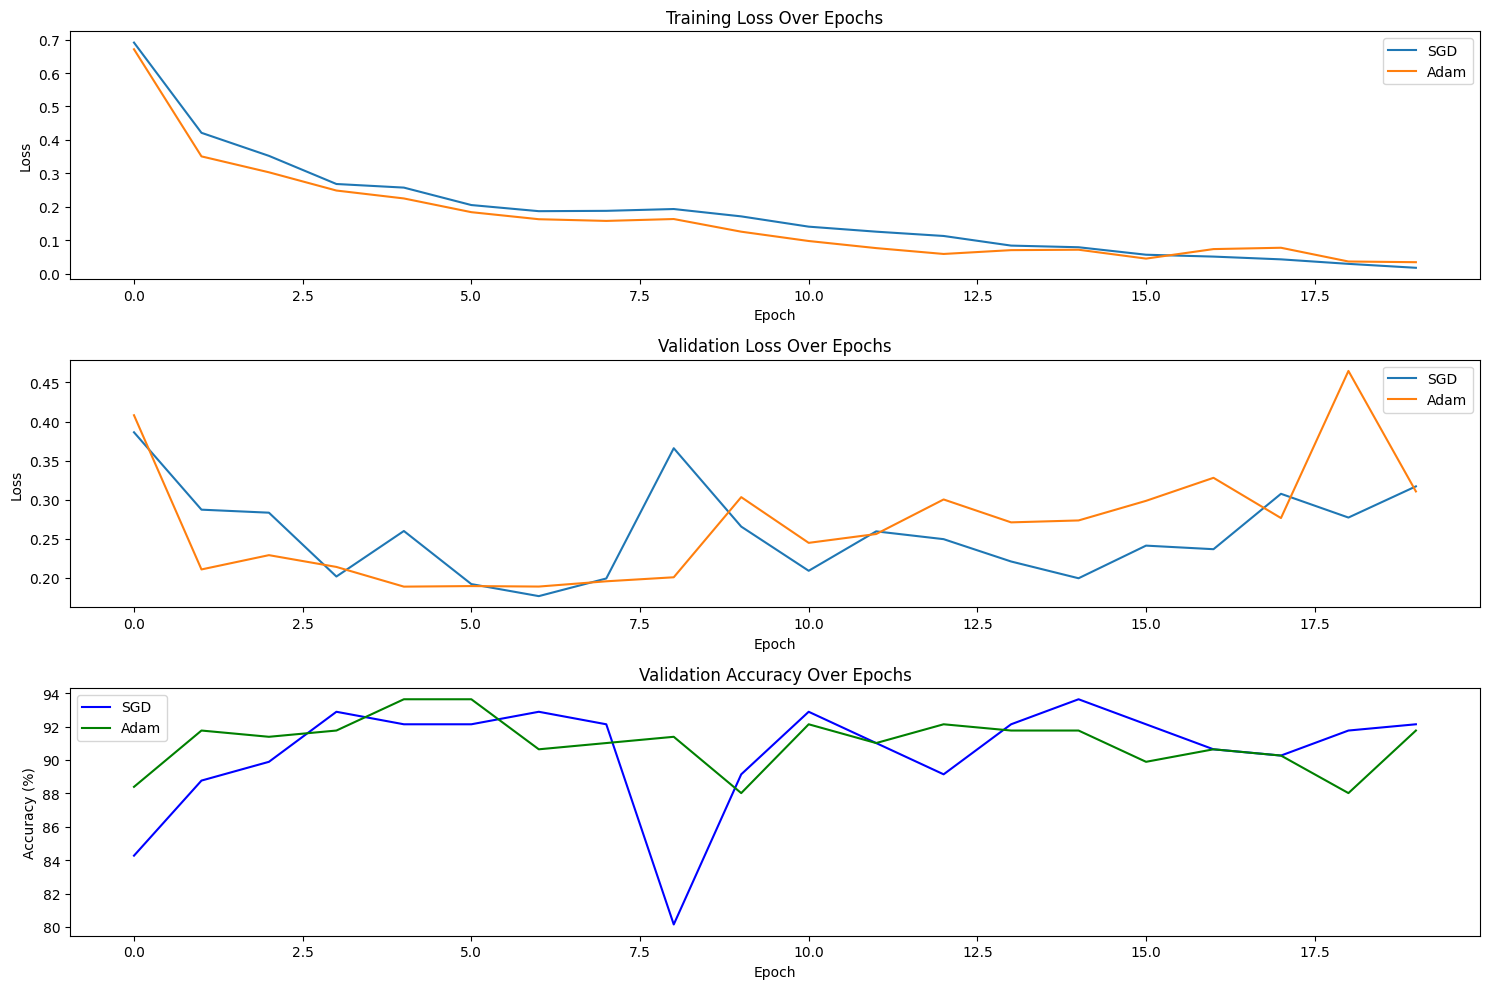

In [37]:
# 학습 손실과 검증 정확도 그래프 그리기
plt.figure(figsize=(15, 10))

# 학습 손실 그래프
plt.subplot(3, 1, 1)  # 3행 1열의 첫 번째 위치
plt.plot(train_losses_SGD, label='SGD')
plt.plot(train_losses_Adam, label='Adam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# 검증 손실 그래프
plt.subplot(3, 1, 2)  # 3행 1열의 두 번째 위치
plt.plot(val_losses_SGD, label='SGD')
plt.plot(val_losses_Adam, label='Adam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

# 검증 정확도 그래프
plt.subplot(3, 1, 3)  # 3행 1열의 세 번째 위치
plt.plot(val_accuracies_SGD, label='SGD', color='blue')
plt.plot(val_accuracies_Adam, label='Adam', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()